In [2]:
import numpy as np 
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch, sys, os 
import json 
import scanpy as sc
from scipy import stats
sys.path.append(os.path.dirname(os.getcwd()))  # parent of `perturbgene` directory

from perturbgene.model import GeneBertForPhenotypicMLM
from perturbgene.attribution_utils import (
    get_model,
    get_tokenizer,
    cell_sampling,
    prepare_cell
)
from perturbgene.gene_pruning.attribution import AttributionAnalysis
from perturbgene.data_utils import read_h5ad_file 

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"
model_path = "attribution_data/checkpoint-1360000"
file_directory = "attribution_sets"


model = get_model(GeneBertForPhenotypicMLM, model_path, device)
model.to(device)
model.eval()
model.zero_grad()
model_type = "mlm"

# Step 2: Load tokenizer
tokenizer = get_tokenizer(model_type, model_path, None)
validation_data = read_h5ad_file(file_directory + "/cxg_chunk3560.h5ad", tokenizer.config.num_top_genes)

def geometric_importance(attr1: torch.tensor, attr2: torch.tensor):
    return torch.where(
        (attr1 == 0) & (attr2 == 0),
        torch.tensor(0.0, device=attr1.device),
        torch.where(
            (attr1 == 0) | (attr2 == 0),
            torch.max(attr1.abs(), attr2.abs()),
            torch.sqrt(attr1.abs() * attr2.abs()),
        ),
    )


def arithmetic_importance(attr1: torch.tensor, attr2: torch.tensor):
    return (attr1 + attr2) / 2


def identity_importance(reverse: bool = False):
    return (lambda attr1, attr2: attr1) if not reverse else (lambda attr1, attr2: attr2)


def random_importance(attr1: torch.tensor, attr2: torch.tensor):
    return torch.randperm(attr1.size(0), device=attr1.device)

def map_token_to_name(token_type_id, offset = 7):
    index = token_type_id-offset
    return validation_data.var.iloc[index]["feature_name"]

def map_id_to_name(id):
    return validation_data.var[validation_data.var["feature_id"] == id]["feature_name"][0]

/Users/biggu/Desktop/perturbgene/venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [83]:
disease = pd.read_csv("gene_pruning/data/target_breast.csv")
# disease = disease.groupby("token_type_id").filter(lambda x: len(x) >= 10)
# normal = normal.groupby("token_type_id").filter(lambda x: len(x) >= 10)
plt.rcParams['font.size'] = 9  # Set default font size
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8


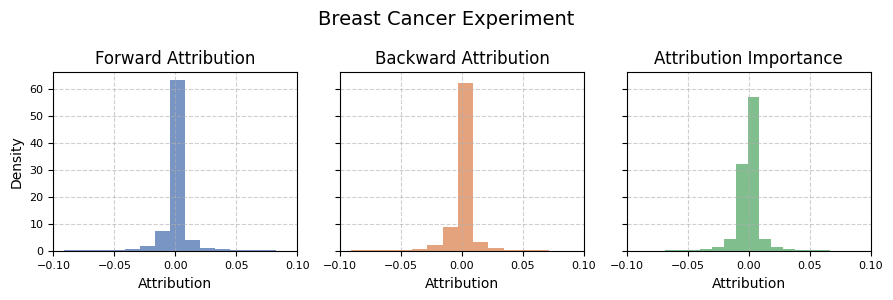

In [84]:

# Data
disease_attr = disease["attribution"]
normal_attr = disease["rev_attrbution"]
mean_attr = (disease_attr + normal_attr) / 2

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# Common histogram settings
bins = 150
x_limits = (-0.1, 0.1)
colors = ["#4c72b0", "#dd8452", "#55a868"]  # Custom colors

# Titles for subplots
titles = [
    "Forward Attribution",
    "Backward Attribution",
    "Attribution Importance"
]
data = [disease_attr, normal_attr, mean_attr]

# Plot each histogram
for i, ax in enumerate(axes):
    ax.hist(data[i], bins=bins, density=True, color=colors[i], alpha=0.75)
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Attribution", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

# Set y-axis label only for the first subplot
axes[0].set_ylabel("Density", fontsize=10)

# Set x-axis limits and adjust layout
axes[0].set_xlim(x_limits)
fig.suptitle("Breast Cancer Experiment", fontsize=14)
plt.tight_layout()

# Save the figure in high resolution for ICLR
plt.savefig("figures/breast_attribution.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()



In [ ]:
disease_attr
normal_attr
mean_attr 

In [36]:
print(stats.mode(disease_attr).count/5944554*100)
print(stats.mode(normal_attr).count/5944554*100)
print(stats.mode(mean_attr).count/5944554*100)
print(len(disease_attr))

59.762851847253806
38.468167670779
3.5708313861729577
5944554


In [37]:
print(np.median(disease_attr))
print(np.median(normal_attr))
print(np.median(mean_attr))
print(len(disease_attr))

0.0
0.0
0.0
5944554


In [38]:
print(np.mean(disease_attr))
print(np.mean(normal_attr))
print(np.mean(mean_attr))
print(len(disease_attr))

0.0004946754309582071
8.676144179149056e-05
0.00029071843637484937
5944554


In [31]:
print(np.std(disease_attr))
print(np.std(normal_attr))
print(np.std(mean_attr))
print(len(disease_attr))

0.020501421759297662
0.02050720528360122
0.014755019019798928
5944554


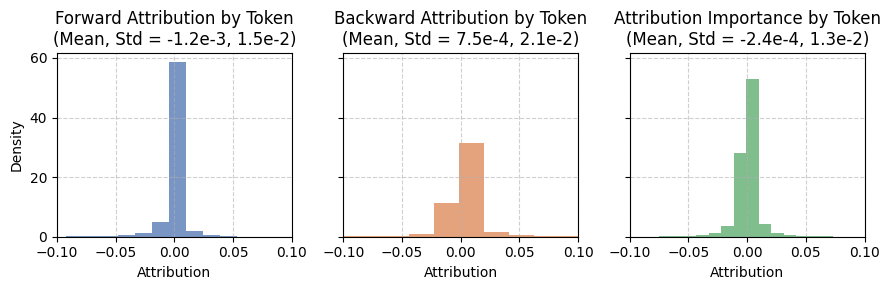

In [11]:
disease = pd.read_csv("gene_pruning/data/target_alzheimer.csv")
disease = disease.groupby("token_type_id")
disease_attr = disease["attribution"].mean()
normal_attr = disease["rev_attrbution"].mean()
mean_attr = ((disease_attr + normal_attr)/2)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# Common histogram settings
bins = 50
x_limits = (-0.1, 0.1)
colors = ["#4c72b0", "#dd8452", "#55a868"]  # Custom colors

# Titles for subplots
titles = [
    "Forward Attribution by Token\n(Mean, Std = -1.2e-3, 1.5e-2)",
    "Backward Attribution by Token\n(Mean, Std = 7.5e-4, 2.1e-2)",
    "Attribution Importance by Token\n(Mean, Std = -2.4e-4, 1.3e-2)"
]
data = [disease_attr, normal_attr, mean_attr]

# Plot each histogram
for i, ax in enumerate(axes):
    ax.hist(data[i], bins=bins, density=True, color=colors[i], alpha=0.75)
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Attribution", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

# Set y-axis label only for the first subplot
axes[0].set_ylabel("Density", fontsize=10)

# Set x-axis limits and adjust layout
axes[0].set_xlim(x_limits)
plt.tight_layout()

# Save the figure in high resolution for ICLR
plt.savefig("figures/alzheimer_attribution_by_token.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

In [81]:
print(stats.mode(disease_attr).count/len(disease_attr)*100)
print(stats.mode(normal_attr).count/len(disease_attr)*100)
print(stats.mode(mean_attr).count/len(disease_attr)*100)
print(len(disease_attr))

34.568552927927925
3.3572635135135136
0.010557432432432432
28416


In [92]:
stats.mode(disease_attr)

ModeResult(mode=0.0, count=9823)

In [91]:
stats.mode(mean_attr)

ModeResult(mode=0.0, count=3)

In [82]:
print(np.mean(disease_attr))
print(np.mean(normal_attr))
print(np.mean(mean_attr))
print(len(disease_attr))

-0.0012288371484576693
0.0007503111547816313
-0.00023926299683801902
28416


In [83]:
print(np.std(disease_attr))
print(np.std(normal_attr))
print(np.std(mean_attr))
print(len(disease_attr))

0.01478285879567581
0.02162768903606653
0.0131526393161116
28416


In [15]:
disease = disease.groupby("token_type_id").filter(lambda x: len(x) >= 10)
mean_attr_by_token = disease.groupby("token_type_id")["attribution"].mean()
count_by_token = disease["token_type_id"].value_counts().sort_index()
mean_attr = pd.DataFrame({
    "mean_attribution": mean_attr_by_token,
    "count": count_by_token
})
mean_attr["gene_name"]= [map_token_to_name(id) for id in mean_attr.index]
mean_attr = mean_attr.sort_values(by="mean_attribution", ascending=False)
mean_attr[0:10]

,mean_attribution,count,gene_name
46391,0.218629,19,RGPD4-AS1
10068,0.160760,18,MIOX
5271,0.151928,28,CIART
52442,0.132727,25,FAM157B
48289,0.124379,20,RP11-826N14.8
20563,0.108513,22,BSN-DT
17349,0.107265,1344,DDIT4
57777,0.105772,23,ZRSR2P1
46268,0.102535,30,LINC01529
52999,0.087074,136,RP1-17K7.2


In [15]:
target = pd.read_csv("target_alzheimer.csv")
target = target.groupby("token_type_id").filter(lambda x: len(x) >= 10)
print(f"There are {len(target['token_type_id'].unique())} genes in a disease cell.")

There are 18785 genes in a disease cell.


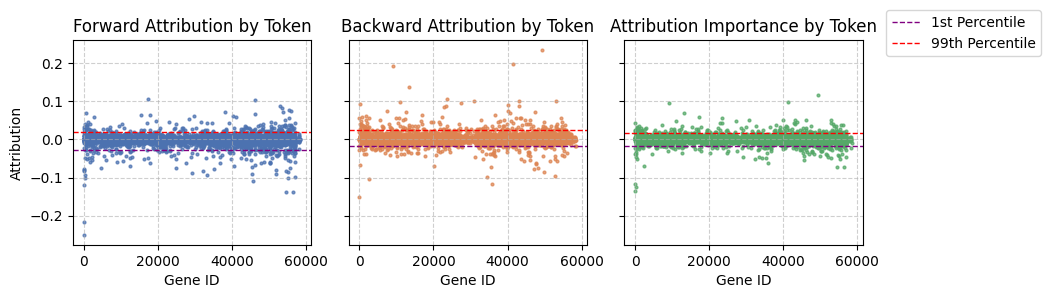

In [6]:
disease = pd.read_csv("gene_pruning/data/target_alzheimer.csv").groupby("token_type_id").filter(lambda x : len(x)>= 30)
disease = disease.groupby("token_type_id")
disease_attr = disease["attribution"].mean()
normal_attr = disease["rev_attrbution"].mean()
mean_attr = ((disease_attr + normal_attr)/2)

handles = []  # Store legend handles
labels = []   # Store legend labels


fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# Common histogram settings
colors = ["#4c72b0", "#dd8452", "#55a868"]  # Custom colors

# Titles for subplots
titles = [
    "Forward Attribution by Token",
    "Backward Attribution by Token",
    "Attribution Importance by Token"
]
data = [disease_attr, normal_attr, mean_attr]

# Plot each histogram
for i, ax in enumerate(axes):
    ax.scatter(data[i].index, data[i].values, s=4, marker='o', label='Global Attribution Values', color=colors[i], alpha=0.75)
    p10 = np.percentile(data[i].values, 1)  # 10th percentile
    p90 = np.percentile(data[i].values, 99)  # 90th percentile
    h1 = ax.axhline(p10, color='purple', linestyle='dashed', linewidth=1)
    h2 = ax.axhline(p90, color='red', linestyle='dashed', linewidth=1)
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Gene ID", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

    if i == 0:
        handles.extend([h1, h2])
        labels.extend([r"1st Percentile", "99th Percentile"])

# Add the legend outside the figure
fig.legend(handles, labels, loc='upper right', fontsize=10, bbox_to_anchor=(1.17, 1))  

# Set y-axis label only for the first subplot
axes[0].set_ylabel("Attribution", fontsize=10)

# Set x-axis limits and adjust layout
plt.tight_layout()

# Save the figure in high resolution for ICLR
plt.savefig("figures/alzhimer_attribution_by_token.png")
# Show the figure
plt.show()

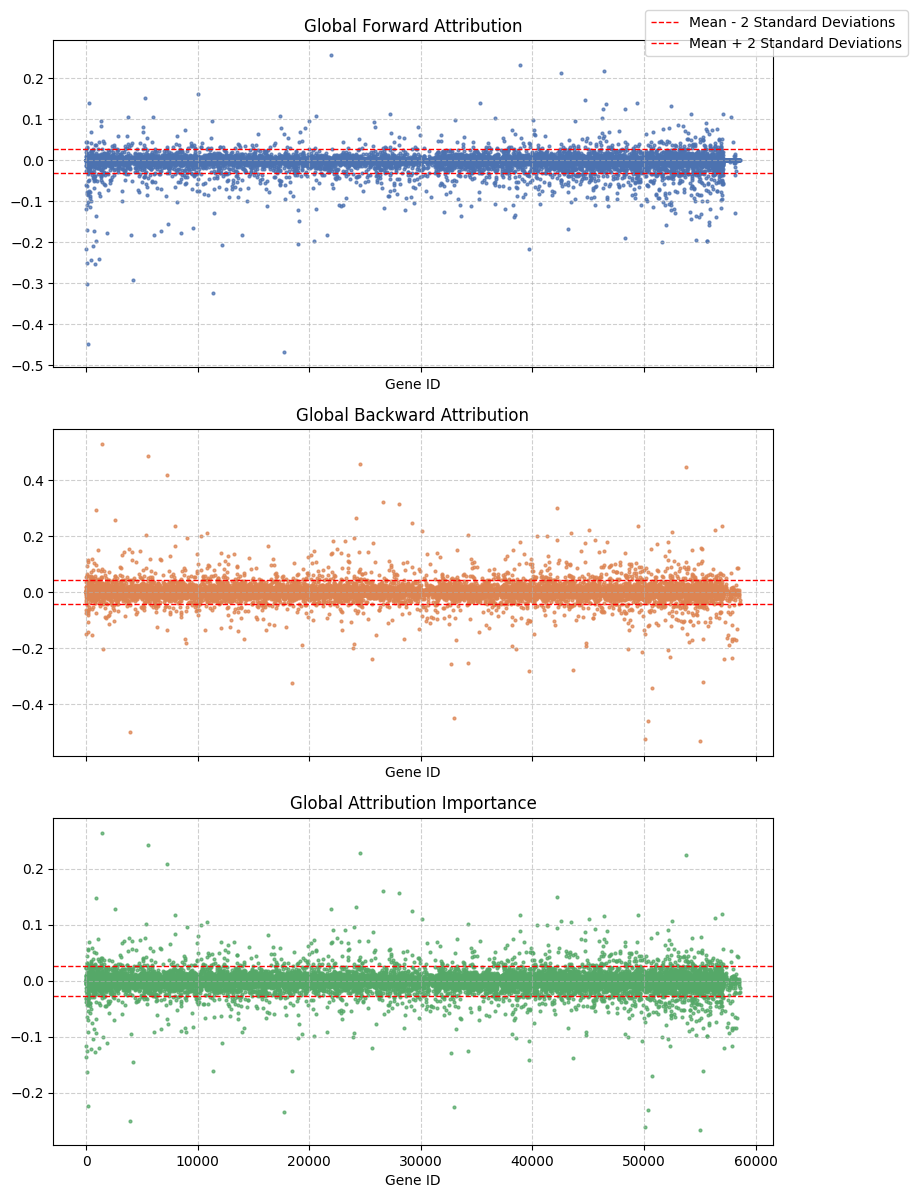

In [25]:

fig, axes = plt.subplots(nrows=len(data), figsize=(8, len(data) * 4), sharex=True)

handles = []  # Store legend handles
labels = []   # Store legend labels

for i, ax in enumerate(axes):
    ax.scatter(data[i].index, data[i].values, s=4, marker='o', label='Global Attribution Values', color=colors[i], alpha=0.75)
    
    sd = np.std(data[i].values)
    mean = np.mean(data[i].values)
    
    h1 = ax.axhline(mean - 2*sd, color='r', linestyle='dashed', linewidth=1, label="Mean - 2 Standard Deviations")
    h2 = ax.axhline(mean + 2*sd, color='r', linestyle='dashed', linewidth=1, label="Mean + 2 Standard Deviations")

    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Gene ID", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Collect legend handles and labels only from the first plot
    if i == 0:
        handles.extend([h1, h2])
        labels.extend(["Mean - 2 Standard Deviations", "Mean + 2 Standard Deviations"])

# Add the legend outside the figure
fig.legend(handles, labels, loc='upper right', fontsize=10, bbox_to_anchor=(1.15, 1))  

plt.tight_layout()
plt.show()


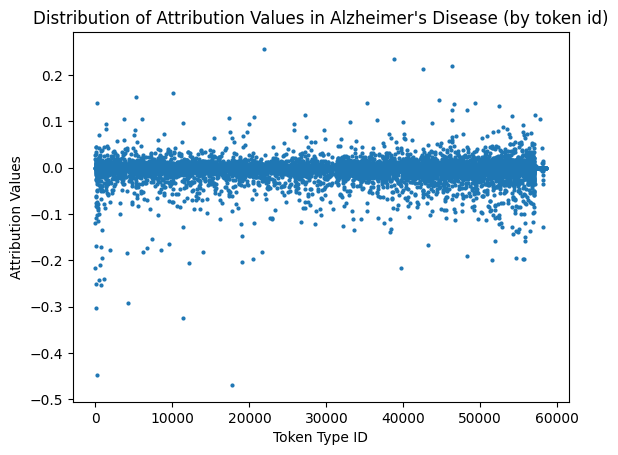

In [5]:
plt.figure()
plt.title("Distribution of Attribution Values in Alzheimer's Disease (by token id)")
plt.scatter(disease_attr.index, disease_attr.values, s=4, marker='o', label='Global Attribution Values')
plt.xlabel("Token Type ID")
plt.ylabel("Attribution Values")
plt.show()

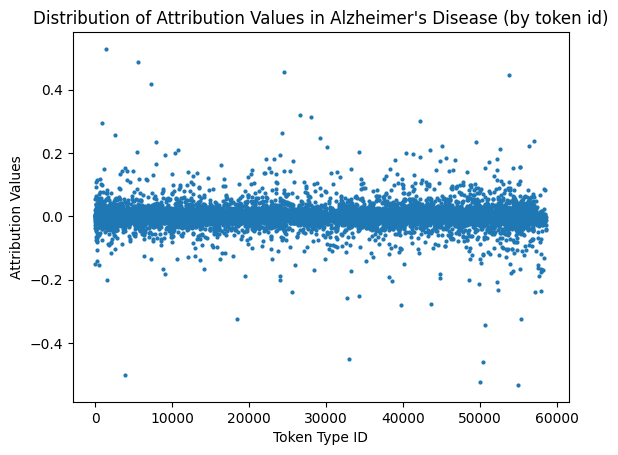

In [6]:
plt.figure()
plt.title("Distribution of Attribution Values in Alzheimer's Disease (by token id)")
plt.scatter(normal_attr.index, normal_attr.values, s=4, marker='o', label='Global Attribution Values')
plt.xlabel("Token Type ID")
plt.ylabel("Attribution Values")
plt.show()

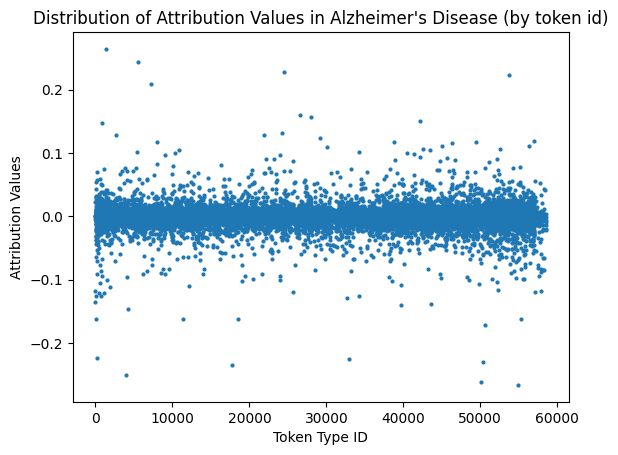

In [7]:
plt.figure()
plt.title("Distribution of Attribution Values in Alzheimer's Disease (by token id)")
plt.scatter(mean_attr.index, mean_attr.values, s=4, marker='o', label='Global Attribution Values')
plt.xlabel("Token Type ID")
plt.ylabel("Attribution Values")
plt.show()

In [96]:
df = pd.read_csv("sample_HVG.csv")
arr = -df["dispersions_norm"]
ranks = arr.argsort()
ranks = ranks.argsort()
df["rank"] = ranks
df.sort_values("rank")
df.to_csv("sample_HVG.csv")

In [101]:
df.head()

,feature_id,highly_variable,means,dispersions,dispersions_norm,rank
0,ENSG00000211893,True,0.252265,6.658512,3.788706,177
1,ENSG00000108849,False,0.003362,6.257889,3.493235,221
2,ENSG00000149021,True,1.049912,7.575086,5.696864,32
3,ENSG00000132465,True,1.890773,7.072406,3.240180,256
4,ENSG00000158578,True,0.088748,4.069074,1.878917,750


In [120]:
rank = df["rank"].loc[[1,5,3]].values
rank

array([221, 319, 256])

In [110]:
-torch.tensor(rank.iloc[[]].values, device=device)

tensor([-221,  -32, -256])

## Biomarkers

In [28]:
target = "dilated" 

disease = pd.read_csv(f"gene_pruning/data/blank_{target}.csv").groupby("token_type_id").filter(lambda x : len(x)>= 5)
normal =  pd.read_csv(f"gene_pruning/data/normal_{target}.csv").groupby("token_type_id").filter(lambda x : len(x)>= 5)
disease = disease.groupby("token_type_id")
normal = normal.groupby("token_type_id")
disease_attr = disease["attribution"].mean()
normal_attr = normal["attribution"].mean()
mean_attr = ((disease_attr - normal_attr)/2).dropna()

In [29]:
k = 30
top_disease = mean_attr.nlargest(k).index
ans = []
for token_id in top_disease:
    ans.append(map_token_to_name(token_id))
print(ans)

['NPPA', 'LINC01115_ENSG00000237667', 'NPPB', 'SAA1', 'H2AC20', 'RP11-380D23.1', 'RP11-701H24.9', 'AC116366.7', 'PARD6G-AS1', 'RP11-114H24.7', 'OSGIN1', 'EDN1', 'COL3A1', 'AP001055.8', 'HSPA6', 'LINGO1', 'RP11-315A19.1', 'KIF25', 'RP11-343C2.9', 'ST3GAL3', 'RP11-813I20.2', 'MALAT1', 'RP11-219A15.1', 'CA4', 'GRXCR2', 'LVRN', 'AC008746.3', 'LINC02641', 'RP11-147H23.3', 'RP11-687M24.8']


In [18]:
target = "dilated"
disease_deg = pd.read_csv(f"gene_pruning/deg_analysis/{target}_DEG.csv")
ans = []
for feature_id in disease_deg.iloc[disease_deg["logfoldchange"].nlargest(k).index]["gene"]:
    ans.append(map_id_to_name(feature_id))
print(ans)


['RP11-305P14.2', 'SNHG14', 'DISC2', 'RP11-115H11.1', 'ZFPM2-AS1', 'POLR2J3_ENSG00000285437', 'RP11-692P14.1', 'LINC01278', 'CHASERR', 'MIR100HG', 'TPT1-AS1', 'DLEU1', 'EIF1B-AS1', 'PPP3R1', 'PSMA3-AS1', 'OIP5-AS1', 'ZNF544', 'GARS1-DT', 'CCDC18-AS1', 'TSTD3', 'ATP5PO', 'HHATL', 'IRF1-AS1', 'DDX39B', 'MIR3936HG', 'FXYD6', 'NPHP3', 'ATXN7', 'AC009120.6', 'RP11-96H17.1']


,Unnamed: 0,gene,logfoldchange,pval,pval_adj,group
0,0,ENSG00000019582,5.910406,0.0,0.0,Alzheimer disease
1,1,ENSG00000166710,5.714970,0.0,0.0,Alzheimer disease
2,2,ENSG00000173369,5.319839,0.0,0.0,Alzheimer disease
3,3,ENSG00000159189,5.263856,0.0,0.0,Alzheimer disease
4,4,ENSG00000231500,6.407538,0.0,0.0,Alzheimer disease
...,...,...,...,...,...,...
117203,117203,ENSG00000231500,-6.407538,0.0,0.0,normal
117204,117204,ENSG00000159189,-5.263856,0.0,0.0,normal
117205,117205,ENSG00000173369,-5.319839,0.0,0.0,normal
117206,117206,ENSG00000166710,-5.714970,0.0,0.0,normal
